FIRST STEPS

In [ ]:
from utils import *
from validation import *

train_images_b, train_labels_b = load_dataset_split_sobel_v5('data/original/balanced/train')
val_images_b, val_labels_b = load_dataset_split_sobel_v5('data/original/balanced/val')
test_images_b, test_labels_b = load_dataset_split_sobel_v5('data/original/balanced/test')

train_images_f, train_labels_f = load_dataset_split_sobel_v5('data/augmented/FracAtlas/train')
val_images_f, val_labels_f = load_dataset_split_sobel_v5('data/augmented/FracAtlas/val')
test_images_f, test_labels_f = load_dataset_split_sobel_v5('data/augmented/FracAtlas/test')

train_images = np.concatenate([train_images_b, train_images_f])
train_labels = np.concatenate([train_labels_b, train_labels_f])
test_images = np.concatenate([test_images_b, test_images_f])
test_labels = np.concatenate([test_labels_b, test_labels_f])
val_images = np.concatenate([val_images_b, val_images_f])
val_labels = np.concatenate([val_labels_b, val_labels_f])





MemoryError: Unable to allocate 3.75 GiB for an array with shape (10231, 128, 128, 3) and data type float64

In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:

class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(train_labels), 
                                   y=train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}


In [ ]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze initially

# Build model
model = keras.Sequential([
    # Preprocessing (equivalent to DenseNet's preprocessing)
    layers.Lambda(lambda x: tf.keras.applications.densenet.preprocess_input(x)),
    
    # Base model
    base_model,
    
    # Custom head
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=["accuracy", 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Same callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
320/320 [==============================] - 53s 138ms/step - loss: 0.6427 - accuracy: 0.6931 - precision: 0.6952 - recall: 0.7678 - auc: 0.7433 - val_loss: 0.8049 - val_accuracy: 0.5462 - val_precision: 0.9467 - val_recall: 0.1187 - val_auc: 0.7677 - lr: 0.0010
Epoch 2/50
320/320 [==============================] - 43s 134ms/step - loss: 0.6588 - accuracy: 0.6139 - precision: 0.6576 - recall: 0.5933 - auc: 0.6677 - val_loss: 0.7541 - val_accuracy: 0.5598 - val_precision: 0.9368 - val_recall: 0.1488 - val_auc: 0.7741 - lr: 0.0010
Epoch 3/50
320/320 [==============================] - 42s 133ms/step - loss: 0.6366 - accuracy: 0.6307 - precision: 0.6775 - recall: 0.6024 - auc: 0.6881 - val_loss: 0.6551 - val_accuracy: 0.6043 - val_precision: 0.8994 - val_recall: 0.2542 - val_auc: 0.7758 - lr: 0.0010
Epoch 4/50
320/320 [==============================] - 41s 130ms/step - loss: 0.6308 - accuracy: 0.6376 - precision: 0.6799 - recall: 0.6203 - auc: 0.6959 - val_loss: 0.6691 - val_accur

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

37/37 [==============================] - 5s 123ms/step - loss: 0.6193 - accuracy: 0.6618 - precision: 0.7110 - recall: 0.6286 - auc: 0.7145
Test Accuracy: 0.6618150472640991
Test Precision: 0.7109515070915222
Test Recall: 0.6285714507102966
Test AUC: 0.7144597768783569


37/37 [==============================] - 8s 119ms/step


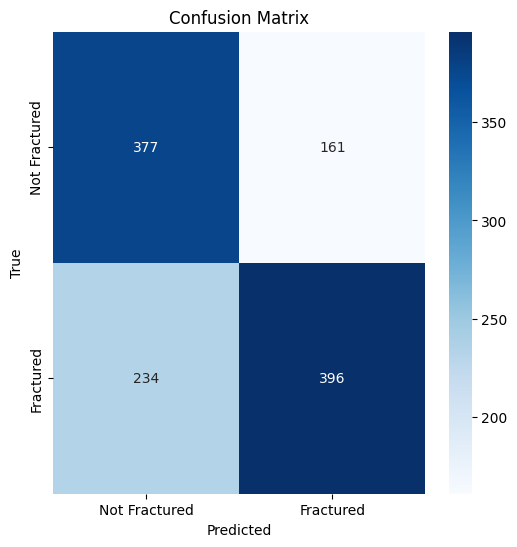

In [ ]:
plot_conf_matrix(model, test_images, test_labels)

In [ ]:
filename = 'binary_model_v6_sobel_transfer.pkl'
create_pkl(filename, model)

In [ ]:
model.save('binary_model_v6_sobel_transfer.keras')

37/37 [==============================] - 5s 140ms/step


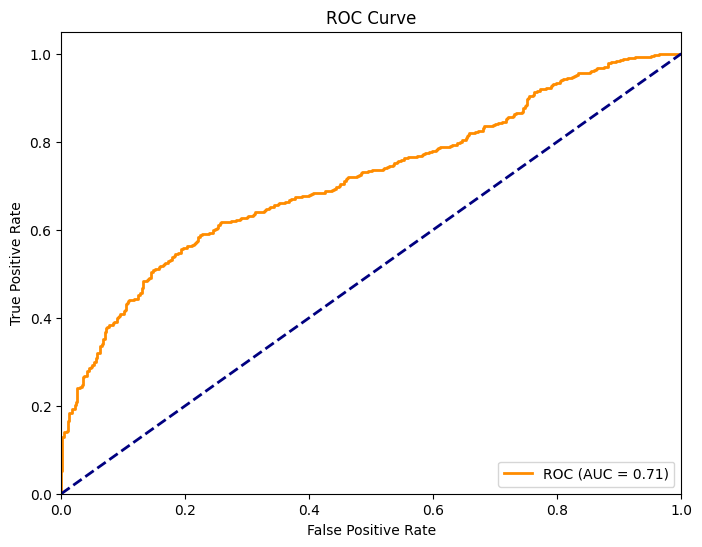

In [ ]:
plot_roc_curve(model, test_images, test_labels)

37/37 [==============================] - 5s 132ms/step


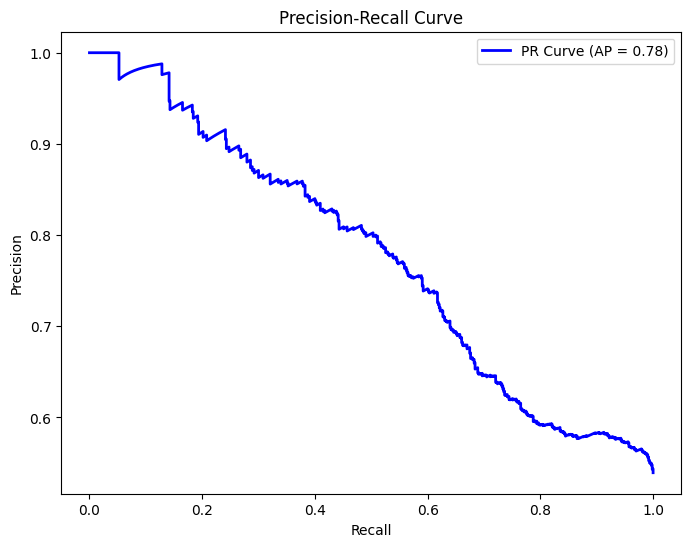

In [ ]:
plot_pr_curve(model, test_images, test_labels)

37/37 [==============================] - 5s 126ms/step


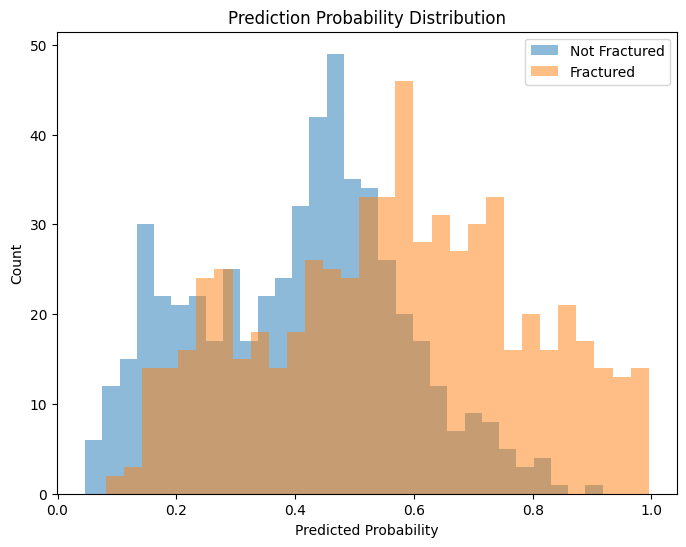

In [ ]:
p_proba_dist(model, test_images, test_labels)

37/37 [==============================] - 5s 124ms/step


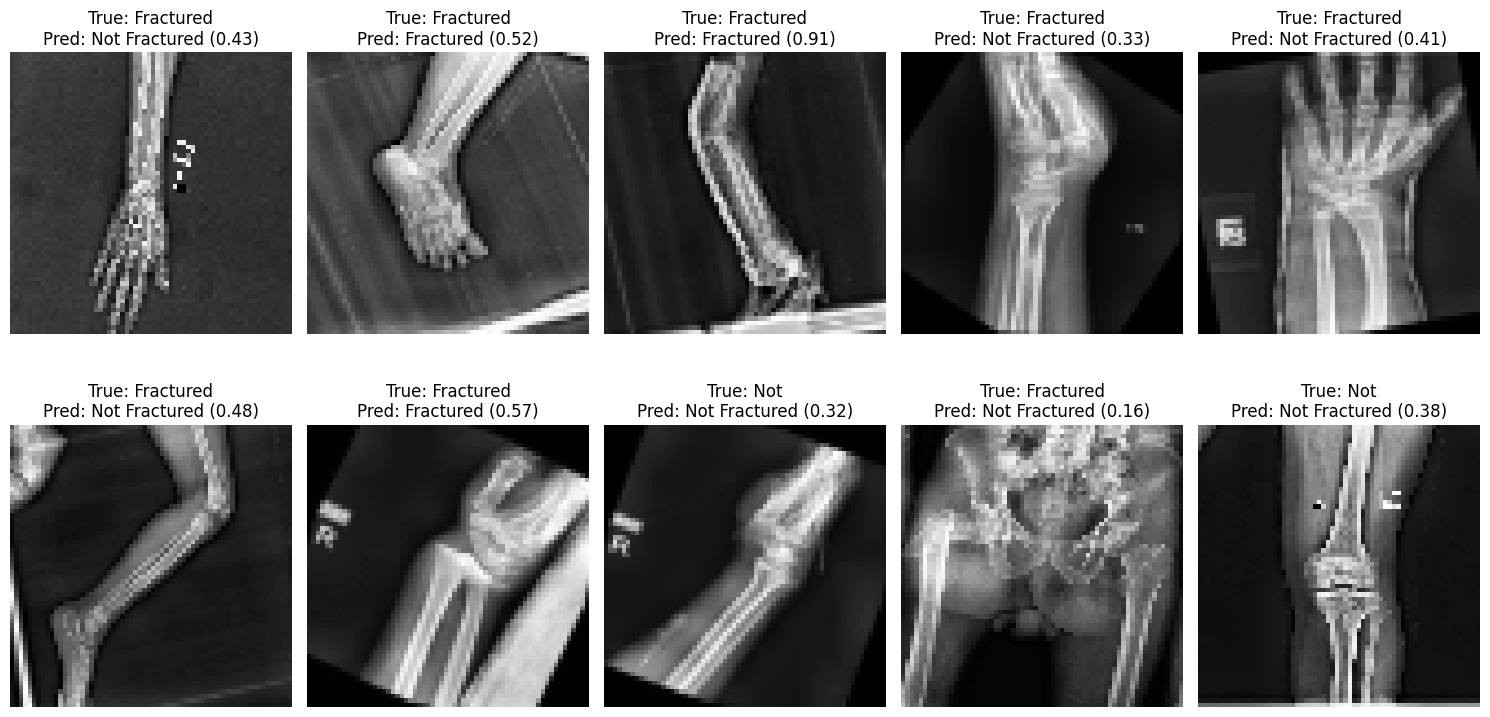

In [ ]:
show_ten_samples(model, test_images, test_labels)

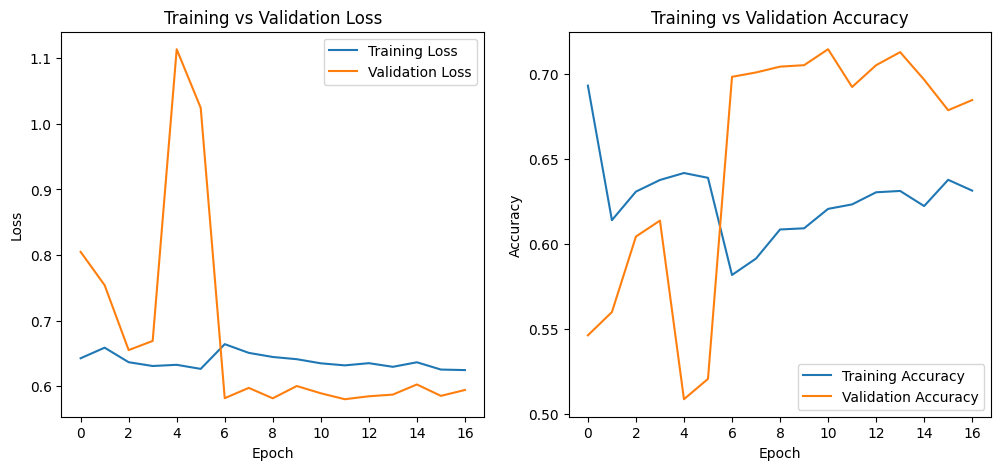

In [ ]:
loss_accu_train(history)

Revisando las métricas, vamos a ajustar 8 epochs el modelo.